### Trajectory analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import geopandas as gpd
import shapely
import skmob
from skmob.measures.individual import jump_lengths
from skmob.tessellation import tilers
from skmob.preprocessing import detection, clustering
from skmob.preprocessing import filtering
from skmob.preprocessing import compression



pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
import warnings
warnings.simplefilter("ignore")
import os

## Preprocessing

In [2]:
"""
    sorting the event data frame by user ID and then by time is the most critical step.
"""
os.chdir('/Users/yingli/Development/TopicsInDataScience/')
events = pd.read_csv("Galapagos Tortoise Movement Ecology Programme_2009-2018.csv", sep=',', parse_dates=[2])
new_cols = pd.Series(events.columns.values).str.replace(pat = r"[-:]", repl="_", regex=True)
tortoise = events.set_axis(labels = new_cols, axis =1)
tortoise.drop(tortoise.index[tortoise["manually_marked_outlier"].notna()], inplace = True)
tortoise.drop(columns =["manually_marked_outlier"], inplace=True)
tortoise.drop(index = tortoise.index[tortoise.isna().any(axis=1)], inplace=True)
cols = ['event_id', 'timestamp', 'location_long', 'location_lat',
       'eobs_temperature', 'ground_speed', 'heading', 'height_above_ellipsoid',
       'individual_local_identifier', 'individual_taxon_canonical_name']
tortoise.drop(columns=tortoise.columns.difference(cols), inplace=True)

tortoise.insert(loc = 2, column = "timestamp_UTC",
                value = tortoise['timestamp'].apply(lambda x: x.tz_localize(tz='UTC'))
                )
tortoise.insert(loc = 3, column = "timestamp_local", 
                value = tortoise["timestamp_UTC"].apply(lambda x: x.tz_convert(tz='US/Pacific'))
                )
tortoise.sort_values(by = ["individual_local_identifier", "timestamp_local"], inplace=True)
tortoise.insert(loc = 4, column = "minute_diff", 
                value = tortoise.groupby(['individual_local_identifier'])["timestamp_local"].diff()\
                    .apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
                    )
tortoise['year'] = tortoise["timestamp_local"].dt.year
tortoise['month'] = tortoise["timestamp_local"].dt.month
tortoise['date'] = tortoise["timestamp_local"].dt.date
tortoise["month_since2009"] = (tortoise.year - tortoise.year.min())*12 + tortoise.month
tortoise["day_since_min"] = (tortoise["timestamp_local"] - tortoise.timestamp_local.min()).apply(lambda x: x.days)
tortoise.reset_index(drop=True, inplace=True)

After all the pre-processing, we make geometry objects and trajectory objects.

In [3]:
tortoise_gdf = gpd.GeoDataFrame(tortoise)
tortoise_gdf["geometry"] = gpd.points_from_xy(tortoise_gdf.location_long, tortoise_gdf.location_lat)
tortoise_trajectory = skmob.TrajDataFrame(tortoise, latitude='location_lat', longitude='location_long', \
    user_id='individual_local_identifier', datetime='timestamp_local', \
)

Adding jump length to trajectory

In [4]:
tortoise_jl = jump_lengths(tortoise_trajectory)
tortoise_jl["jump_lengths"] = \
    tortoise_jl["jump_lengths"].apply(
        lambda x: np.append(x,np.nan).tolist())
tortoise_jl = tortoise_jl.explode(["jump_lengths"],
                ignore_index=True).reset_index(drop=True)
tortoise["jump_length"] = tortoise_jl.jump_lengths
tortoise_trajectory["jump_length"] = tortoise_jl["jump_lengths"]

100%|██████████| 96/96 [00:03<00:00, 31.70it/s]


### Get tessellation, compression, and stay locations 

For all trajectories, use H3 tessellation with resolution 9, scikit-mobility use meters, which maps 200 to resolution 9, 

For stay point, use minutes_for_a_stop = 400, 6.8 hours that the tortoise stayed in the stay location.


To get tessellation, we need to specify the coverage region, either by a geocode of the place name, or by the geopandas data frame that contained the (lat long)'s that need to be covered.

For our study, the geocode name would be "Isla Santa Cruz, Galapagos, Ecuador" for the Santa Cruz Islan, where Alison is, or "Galapagos, Ecuador" for the entire Galapagos region, which also include other islands that contained Christian's data.

In [5]:
import osmnx as ox
place_name = "Galapagos, Ecuador" #Isla Santa Cruz, Galapagos, Ecuador
santa_cruz_gdf = ox.geocode_to_gdf(place_name)
tessellation = tilers.tiler.get("h3_tessellation", base_shape=santa_cruz_gdf,meters =200)
tessellation["tile_lng"] = tessellation.geometry.centroid.x
tessellation["tile_lat"] = tessellation.geometry.centroid.y

In [6]:
tortoise_trajectory_mapping = tortoise_trajectory.mapping(tessellation,remove_na =True) # map trajectory into tessellation tiles
tortoise_tiled = tortoise_trajectory_mapping.merge(tessellation, on = "tile_ID", how = "inner") # join to get the tile coordinates
tortoise_tiled.drop(columns =["lat","lng"], inplace=True) # drop the original lat/lng so that we can create new trajectory
tortoise_tiled.sort_values(by = ["uid", "datetime"], inplace=True) # sort before making trajectory
tortoise_tiled_trajectory = skmob.TrajDataFrame(tortoise_tiled, latitude='tile_lat', longitude='tile_lng', \
    user_id='uid', datetime='datetime', \
)
tortoise_trajectory_compressed = compression.compress(tortoise_trajectory, spatial_radius_km=0.02) # compressed trajectory
tortoise_tiled_trajectory_compressed = compression.compress(tortoise_tiled_trajectory, spatial_radius_km=0.02) # compressed trajectory
tortoise_stay_location = detection.stay_locations(tortoise_trajectory, 
    stop_radius_factor=0.02, minutes_for_a_stop=400, spatial_radius_km=0.2, leaving_time=True)

 - get Alison data for experiment

In [7]:
alison = tortoise[tortoise["individual_local_identifier"] == "Alison"]
alison_gdf = tortoise_gdf[tortoise_gdf["individual_local_identifier"] == "Alison"]
alison_trajectory = tortoise_trajectory.query("uid == 'Alison'")
alison_trajectory_mapping = tortoise_trajectory_mapping.query("uid == 'Alison'")
alison_tiled_trajectory = tortoise_tiled_trajectory.query("uid == 'Alison'")
alison_trajectory_compressed = tortoise_trajectory_compressed.query("uid == 'Alison'")
alison_tiled_trajectory_compressed = tortoise_tiled_trajectory_compressed.query("uid == 'Alison'")
alison_stay_location = tortoise_stay_location.query("uid == 'Alison'")

In [8]:
tortoise_tiled_trajectory.shape, tortoise.shape

((1795892, 22), (1795892, 19))

### prepare auxiliary data
 - set color for consistent visualization
 - set date ranges for slicing trajectories and events

In [9]:
color_list = ['#883399','#66c066', '#ff800c','#60ff78','#301e4b'] # purple, green, orange, lime, dark purple
color_list.extend(list(sns.color_palette('tab10').as_hex()))
color_list = color_list * 3 # extend the list by repeating 3 times

month_date_str = '05-01' # adjust this date for analysis needs
start_year = 2010
end_year = 2019
year_list = range(start_year, end_year)
s_date = []
for i in range(start_year, end_year+1):
    s_date.append(pd.Timestamp(str(i)+'-' +month_date_str).tz_localize(tz = 'US/Pacific'))
e_date = s_date[1:]
s_date.pop()

Timestamp('2019-05-01 00:00:00-0700', tz='US/Pacific')

### plot trajectory, compressed trajectory, and tiled compressed trajectory

In [10]:
alison_plot = alison_trajectory.plot_trajectory(
    hex_color=color_list[0],weight=1, zoom=14, opacity = 0.9,
    tiles = 'OpenStreetMap', 
    )
alison_trajectory_compressed.plot_trajectory(map_f = alison_plot, hex_color = color_list[1],weight = 1, opacity = 0.9)
alison_tiled_trajectory_compressed.plot_trajectory(map_f = alison_plot, hex_color = color_list[2], weight=1, opacity = 0.9)
alison_plot

### plot compressed trajectory by slices of time

In [11]:
june_2013 = pd.Timestamp('2013-06-01',tz='US/Pacific')
dec_2013 = pd.Timestamp('2013-12-01',tz='US/Pacific')
june_2014 = pd.Timestamp('2014-06-01',tz='US/Pacific')
dec_2014 = pd.Timestamp('2014-12-01',tz='US/Pacific')
alison_plot =alison_trajectory_compressed.query("datetime >= @june_2013 and datetime < @dec_2013").plot_trajectory(start_end_markers=True, max_points = 50000, weight=1, opacity=0.9,hex_color='#883399') #purple
alison_trajectory_compressed.query("datetime >= @dec_2013 and datetime < @june_2014").plot_trajectory(map_f = alison_plot, start_end_markers=True, max_points = 50000, weight=1, opacity=0.9,hex_color='#66c066') #green
alison_trajectory_compressed.query("datetime >= @june_2014 and datetime < @dec_2014").plot_trajectory(map_f = alison_plot, start_end_markers=True, max_points = 50000, weight=1, opacity=0.9,hex_color='#ff800c') #orange
alison_plot

### plot trajectory sliced by year

In [12]:
alison_plot = alison_trajectory_compressed.query("year == 2014").plot_trajectory(start_end_markers=True, max_points = 50000, weight=1, opacity=0.9,hex_color= color_list[0])
alison_trajectory_compressed.query("year == 2015").plot_trajectory(map_f=alison_plot, start_end_markers=True, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[1])
alison_trajectory_compressed.query("year == 2016").plot_trajectory(map_f=alison_plot, start_end_markers=True, max_points = 50000, weight=1, opacity=0.9,hex_color=color_list[2])
alison_plot

In [13]:
alison_plot = alison_trajectory.query("year == 2012").plot_trajectory(zoom=14, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#883399')
alison_trajectory.query("year == 2013").plot_trajectory(map_f=alison_plot, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#66c066')
alison_trajectory.query("year == 2014").plot_trajectory(map_f=alison_plot, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#ff800c')
alison_trajectory.query("year == 2015").plot_trajectory(map_f=alison_plot, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#60ff78')
alison_trajectory.query("year == 2016").plot_trajectory(map_f=alison_plot, start_end_markers=False, max_points = 50000, weight=1, opacity=0.9,hex_color='#301e4b')
alison_plot


### Use Folium package directly

We can specify a precise location, a precise zoom level when starting, and more other controls for how the map will look like. 

In [14]:
christian = tortoise.query("individual_local_identifier == 'Christian'")
christian_trajectory = tortoise_trajectory.query("uid == 'Christian'")
christian_trajectory.plot_trajectory(tiles = "OpenStreetMap", zoom = 10)

We see Christian is actually on Isla Isabela, different island from Alison.

The above plot is from scikit-mobility package, which layers on top of folium. If we use folium python package directly, we have more control. Below uses folium python function directly plot the coordinates of Alison, and add Christian's coordinates into the same plot, and we can add the tortoises' names in tooltips.

In [15]:
import folium
alison_coordinates = list(zip(alison.location_lat, alison.location_long))
christian_coordinates = list(zip(christian.location_lat, christian.location_long))

my_plot = folium.Map(location=[-0.75, -90.5], zoom_start=9)
folium.PolyLine(alison_coordinates, tooltip="Alison",weight = 1, color = color_list[0]).add_to(my_plot)
folium.PolyLine(christian_coordinates, tooltip="Christian",weight = 1, color = color_list[2]).add_to(my_plot)
my_plot

We can put it into a function which can keep add plots into.

In [16]:
import folium
def plot_coordinates(df, col_lat = "location_lat", col_long = "location_long", 
                        name = "tortoise",
                        color = '#883399', zoom_start = 8, map_f = None):
    coordinates = list(zip(df[col_lat], df[col_long]))
    if map_f is None:
        map_f = folium.Map(location=[df[col_lat].mean(), df[col_long].mean()], zoom_start= zoom_start, tiles = "OpenStreetMap")
    folium.PolyLine(coordinates, weight = 1, tooltip = name, color = color, tiles = "OpenStreetMap").add_to(map_f)
    return map_f

my_plot = plot_coordinates(alison, name = "Alison", color = color_list[0], zoom_start = 9)
plot_coordinates(christian, name = "Christian", color = color_list[2], map_f = my_plot)
my_plot 

We can use the same function to plot different years, and label the plotlines accordingly with years.

In [17]:
k = 0
alison_plot = None
for i, j in zip(s_date,e_date):
    temp_df = alison[(alison["timestamp_local"] >= i) & (alison["timestamp_local"] < j)].assign()
    alison_plot = plot_coordinates(temp_df, name = i.year,
        color=color_list[k], zoom_start = 13, map_f=alison_plot)
    k = k+1
alison_plot

We can add stay point leaving dates to the plot so that we know when Alison left each of the stay points. We also segment Alison's trajectoies by the migration year. 

In [18]:
alison_stay_segment = []
alison_segment = []
for i, j in zip(s_date,e_date):
    alison_stay_segment.append(alison_stay_location.query("datetime >= @i and datetime < @j"))
    alison_segment.append(alison_trajectory.query("datetime >= @i and datetime < @j"))
alison_stay_coordinates = list(zip(alison_stay_location.lat, alison_stay_location.lng))

alison_plot = folium.Map(location=[alison.location_lat.mean(), alison.location_long.mean()], zoom_start=13)
for i, j, k, year in zip(alison_stay_location.lat, alison_stay_location.lng, alison_stay_location.leaving_datetime, alison_stay_location.year):
    year = year -2011
    folium.CircleMarker(location=[i,j], tooltip = k.date(), radius = 5, weight=1, color = color_list[year]).add_to(alison_plot)
folium.PolyLine(alison_stay_coordinates, weight=1).add_to(alison_plot)
alison_plot


In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return

def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df

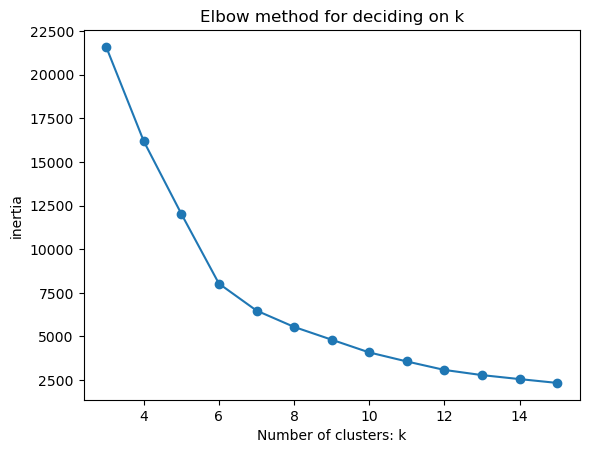

In [20]:
df = alison
colnames = ["location_long", "location_lat","day_since_min"]
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)

#kmeans.cluster_centers_

In [21]:
k = 7
colnames = ["location_long", "location_lat","day_since_min"]
alison_kmeans = run_kmeans(alison, colnames,k,)
alison_kmeans.groupby("cluster").size()

cluster
0     2437
1     3280
2     9275
3    10956
4     1371
5     4339
6     8345
dtype: int64

<Axes: xlabel='location_lat', ylabel='location_long'>

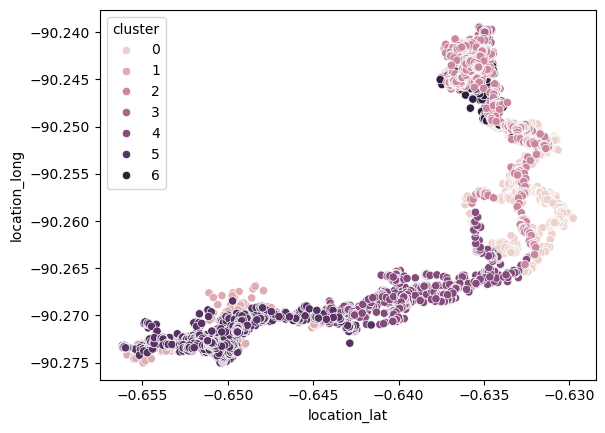

In [22]:
sns.scatterplot(alison_kmeans, x="location_lat", y="location_long", hue="cluster")

In [23]:
k = 0
alison_plot = None
for i in alison.cluster.unique():
    temp_df = alison.query("cluster == @i")
    alison_plot = plot_coordinates(temp_df, name = str(i),
        color=color_list[i], zoom_start = 13, map_f=alison_plot)
alison_plot

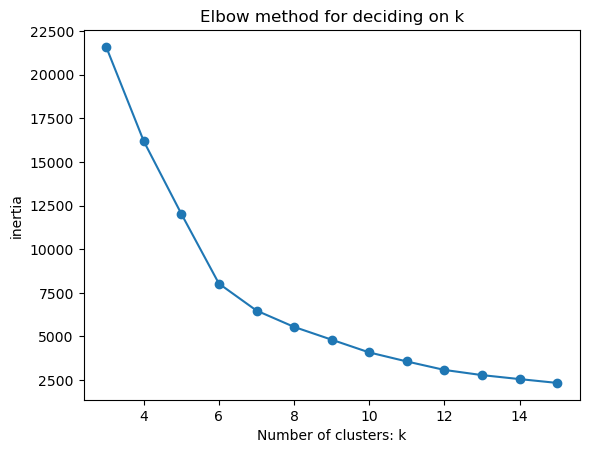

In [24]:
df = alison_trajectory
colnames = ["lng", "lat", "day_since_min"]
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)

#kmeans.cluster_centers_

In [25]:
k = 7
alison_trajectory_kmeans = run_kmeans(alison_trajectory, colnames,k,)
alison_trajectory_kmeans.groupby("cluster").size()

cluster
0     2437
1     3280
2     9275
3    10956
4     1371
5     4339
6     8345
dtype: int64

In [26]:
alison_kmeans.cluster.value_counts()

cluster
3    10956
2     9275
6     8345
5     4339
1     3280
0     2437
4     1371
Name: count, dtype: int64

In [27]:
my_plot = plot_coordinates(alison_kmeans.query("cluster == 1"), name = "cluster 1", color = color_list[0], zoom_start = 9)
plot_coordinates(alison_kmeans.query("cluster == 2"), name = "cluster 2", color = color_list[2], map_f = my_plot)
my_plot 

<Axes: xlabel='location_lat', ylabel='location_long'>

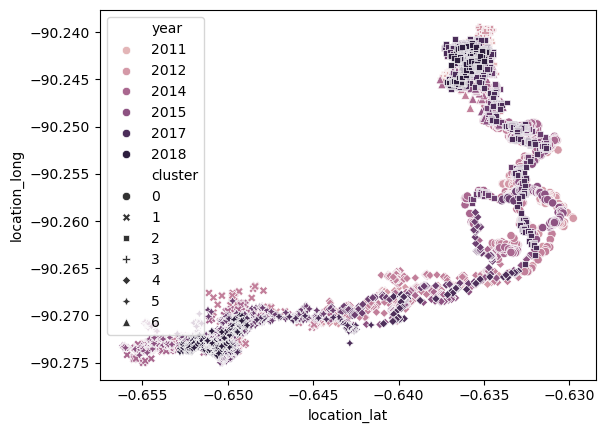

In [28]:
sns.scatterplot(alison_kmeans, x="location_lat", y="location_long",hue= "year", style ="cluster")

In [29]:
pd.DataFrame(data = zip(alison_kmeans.groupby("cluster")["timestamp_local"].min(), alison_kmeans.groupby("cluster")["timestamp_local"].max()))

0                                1
0 2012-10-20 09:01:24.998000-07:00 2016-05-28 07:00:56.001000-07:00
1        2012-12-27 15:00:44-08:00        2014-04-14 06:01:00-07:00
2 2016-05-24 10:00:23.001000-07:00 2018-10-01 09:00:29.998000-07:00
3 2010-09-17 10:01:25.998000-07:00        2012-10-20 08:00:56-07:00
4 2012-12-19 10:00:55.998000-08:00        2017-11-16 12:01:26-08:00
5 2015-11-12 11:01:26.999000-08:00        2018-03-12 18:00:56-07:00
6 2013-06-24 09:01:22.998000-07:00 2015-10-26 09:01:19.999000-07:00

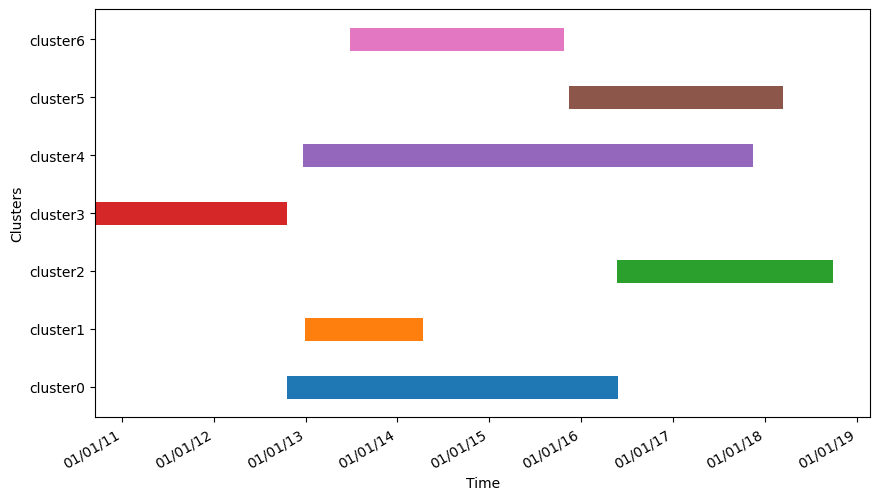

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

alison_start = alison_kmeans.groupby("cluster")["timestamp_local"].min()
alison_end = alison_kmeans.groupby("cluster")["timestamp_local"].max()
labels = ["cluster"+str(i) for i in range(0, alison_kmeans.cluster.nunique())]

fig, ax = plt.subplots(figsize=(10, 6))
for i, (start, end) in enumerate(zip(alison_start, alison_end)):
    ax.barh(i, (end - start).days, left=mdates.date2num(start), height=0.4)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels )
plt.xlabel('Time')
plt.ylabel('Clusters')
plt.gcf().autofmt_xdate()
plt.show()
